<a href="https://colab.research.google.com/github/Oleksij-gh/PersonaFilmRecommender/blob/main/RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Global parameters

In [1]:
seed = 42

# Data

## Donload and Unzip

In [2]:
# Download data
!gdown 1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF

# Unzip data
import zipfile
with zipfile.ZipFile('/content/RecSys.zip') as zip:
    zip.extractall('/content/data')




Downloading...
From: https://drive.google.com/uc?id=1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF
To: /content/RecSys.zip
100% 9.92M/9.92M [00:00<00:00, 58.7MB/s]


## Preprocessing

In [1]:
import pandas as pd

In [3]:
person_data = pd.read_csv('/content/data/2018-personality-data.csv')
rating_data = pd.read_csv('/content/data/2018_ratings.csv')

In [4]:
person_data = person_data.drop([' assigned metric',
       ' assigned condition', ' movie_1', ' predicted_rating_1', ' movie_2',
       ' predicted_rating_2', ' movie_3', ' predicted_rating_3', ' movie_4',
       ' predicted_rating_4', ' movie_5', ' predicted_rating_5', ' movie_6',
       ' predicted_rating_6', ' movie_7', ' predicted_rating_7', ' movie_8',
       ' predicted_rating_8', ' movie_9', ' predicted_rating_9', ' movie_10',
       ' predicted_rating_10', ' movie_11', ' predicted_rating_11',
       ' movie_12', ' predicted_rating_12', ' is_personalized',
       ' enjoy_watching '], axis=1)

In [5]:
person_data

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5
...,...,...,...,...,...,...
1829,cff910b71f09b3120289ff6b461a9e03,5.5,3.5,2.5,4.0,5.5
1830,1ab3a4c2921d8da640854819b0f6cfce,4.0,3.5,4.5,4.0,2.5
1831,a06386edadf3bc614dadb7044708c46c,6.0,3.0,5.5,3.5,6.0
1832,bad56d9506832cd79d874a6b66b3d813,5.0,3.5,1.5,3.5,2.5


In [6]:
rating_data = rating_data.rename({'useri': 'userid'}, axis=1)

In [7]:
rating_data.shape

(1028751, 4)

In [8]:
data = person_data.merge(rating_data, how="inner", on=['userid'])

In [9]:
data.shape

(1070203, 9)

In [10]:
person_data.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5


In [12]:
rating_data.head()

,userid,movie_id,rating,tstamp
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02


In [11]:
data = data.drop(['userid', ' tstamp '], axis=1)
data.head()

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,movie_id,rating
0,5.0,2.0,3.0,2.5,6.5,1,5.0
1,5.0,2.0,3.0,2.5,6.5,2,4.0
2,5.0,2.0,3.0,2.5,6.5,3,4.0
3,5.0,2.0,3.0,2.5,6.5,5,5.0
4,5.0,2.0,3.0,2.5,6.5,6,4.0


In [12]:
data[' rating'].astype('int').value_counts()

 rating
3    416879
4    348024
2    158296
5     72821
1     52546
0     21637
Name: count, dtype: int64

<Axes: >

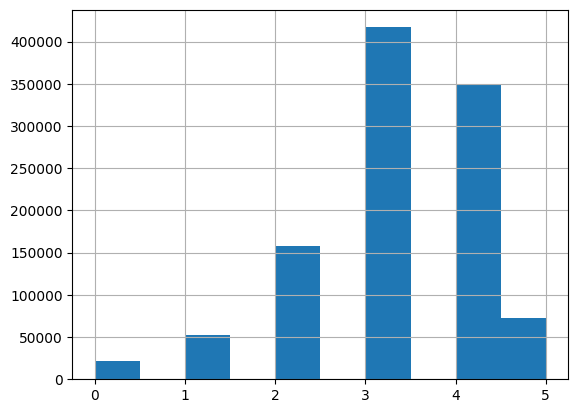

In [13]:
data[' rating'].astype('int').hist()

In [15]:
df = data.copy()

In [16]:
from sklearn.preprocessing import OneHotEncoder

df[' movie_id'] = df[' movie_id'].astype(object)

In [18]:
!pip install category_encoders --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00


In [21]:
import category_encoders as ce

In [22]:
encoder=ce.HashingEncoder(cols=[' movie_id'],n_components=6)
df = encoder.fit_transform(df)
df

,col_0,col_1,col_2,col_3,col_4,col_5,openness,agreeableness,emotional_stability,conscientiousness,extraversion,rating
0,0,1,0,0,0,0,5.0,2.0,3.0,2.5,6.5,5.0
1,1,0,0,0,0,0,5.0,2.0,3.0,2.5,6.5,4.0
2,0,1,0,0,0,0,5.0,2.0,3.0,2.5,6.5,4.0
3,0,0,0,1,0,0,5.0,2.0,3.0,2.5,6.5,5.0
4,1,0,0,0,0,0,5.0,2.0,3.0,2.5,6.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1070198,0,0,1,0,0,0,6.5,6.5,2.5,6.5,2.0,1.5
1070199,0,1,0,0,0,0,6.5,6.5,2.5,6.5,2.0,4.5
1070200,0,0,0,0,1,0,6.5,6.5,2.5,6.5,2.0,3.5
1070201,0,0,1,0,0,0,6.5,6.5,2.5,6.5,2.0,4.0


In [138]:
X = data.drop(' rating', axis = 1).values.astype('float32')
y = data[' rating'].values.astype('int')

In [123]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed, replacement=True)

X, y = rus.fit_resample(X, y)

# NN

## Split data

In [96]:
from sklearn.model_selection import train_test_split

def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

  return X_train, y_train, X_val, y_val, X_test, y_test

## Pytorch

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import copy
import numpy as np

In [23]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [124]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [102]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Define train dataloader

In [126]:
train_data = Data(X_train, y_train)
train_dl = DataLoader(dataset=train_data, batch_size=32)

Define validate data

In [127]:
val_data = Data(X_val, y_val)
valid_dl = DataLoader(dataset=val_data, batch_size=32)

Define test data

In [128]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test


In [129]:
class Model(nn.Module):

    def __init__(self, input_shape, output_shape=6):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(input_shape, 16)
        self.fc2 = nn.Linear(16, 32)
        self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_shape)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.dropout(x)
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)

        return x


In [130]:
learning_rate = 1e-3

model = Model(X_train.shape[1], len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training parameters
n_epochs = 10   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
history_loss = []
history_acc = []
history_val_loss = []
history_val_acc = []

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 1286
Total params count: 1286


In [131]:
# training loop
for epoch in range(n_epochs):
  print(f'Epoch {epoch}')
  model.train()
  for X_train, y_train in tqdm(train_dl):

    # forward pass
    y_pred = model(X_train)

    # calculate loss
    loss = criterion(y_pred, y_train)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    # update weights
    optimizer.step()

    # calculate accuracy
    acc = (torch.argmax(y_pred, 1) == y_train).float().mean()
    history_acc.append(acc)

  print(f'Train Loss: {loss} | Accuracy: {acc}')
  history_loss.append(float(loss))

  # evaluate
  model.eval()
  loss_val = 0
  acc_val = 0

  with torch.no_grad():
    for X_val, y_val in valid_dl:
      pred_val = model(X_val)
      loss_val += criterion(pred_val, y_val)
      acc_val += (torch.argmax(pred_val, 1) == y_val).float().mean()

    # calculate valid loss, acc
    loss_val /= len(valid_dl)
    acc_val /= len(valid_dl)
    history_val_loss.append(loss_val)
    history_val_acc.append(acc_val)

    print(f'Validate Loss: {loss_val} | Accuracy: {acc_val}')
    print('-'*30)

    # store best model
    if loss_val < best_loss:
      best_loss = loss_val
      best_model_wts = copy.deepcopy(model.state_dict())

Epoch 0


100%|██████████| 2435/2435 [00:05<00:00, 414.21it/s]


Train Loss: 1.7848949432373047 | Accuracy: 0.5
Validate Loss: 1.7917338609695435 | Accuracy: 0.16517560184001923
------------------------------
Epoch 1


100%|██████████| 2435/2435 [00:04<00:00, 510.34it/s]


Train Loss: 1.7877891063690186 | Accuracy: 0.5
Validate Loss: 1.7916789054870605 | Accuracy: 0.16417498886585236
------------------------------
Epoch 2


100%|██████████| 2435/2435 [00:04<00:00, 511.25it/s]


Train Loss: 1.7879095077514648 | Accuracy: 0.5
Validate Loss: 1.7916244268417358 | Accuracy: 0.16498318314552307
------------------------------
Epoch 3


100%|██████████| 2435/2435 [00:05<00:00, 443.57it/s]


Train Loss: 1.7883188724517822 | Accuracy: 0.5
Validate Loss: 1.7915840148925781 | Accuracy: 0.16517560184001923
------------------------------
Epoch 4


100%|██████████| 2435/2435 [00:05<00:00, 413.85it/s]


Train Loss: 1.7886079549789429 | Accuracy: 0.5
Validate Loss: 1.7915563583374023 | Accuracy: 0.16517560184001923
------------------------------
Epoch 5


100%|██████████| 2435/2435 [00:05<00:00, 419.90it/s]


Train Loss: 1.78821861743927 | Accuracy: 0.5
Validate Loss: 1.791481614112854 | Accuracy: 0.16498318314552307
------------------------------
Epoch 6


100%|██████████| 2435/2435 [00:04<00:00, 515.97it/s]


Train Loss: 1.7886314392089844 | Accuracy: 0.5
Validate Loss: 1.7915451526641846 | Accuracy: 0.16494469344615936
------------------------------
Epoch 7


100%|██████████| 2435/2435 [00:06<00:00, 351.59it/s]


Train Loss: 1.7884342670440674 | Accuracy: 0.5
Validate Loss: 1.7914230823516846 | Accuracy: 0.16498318314552307
------------------------------
Epoch 8


100%|██████████| 2435/2435 [00:05<00:00, 483.25it/s]


Train Loss: 1.788299798965454 | Accuracy: 0.5
Validate Loss: 1.7914793491363525 | Accuracy: 0.16479074954986572
------------------------------
Epoch 9


100%|██████████| 2435/2435 [00:05<00:00, 468.95it/s]


Train Loss: 1.7883371114730835 | Accuracy: 0.5
Validate Loss: 1.7915141582489014 | Accuracy: 0.16479074954986572
------------------------------


In [52]:
from matplotlib import pyplot as plt

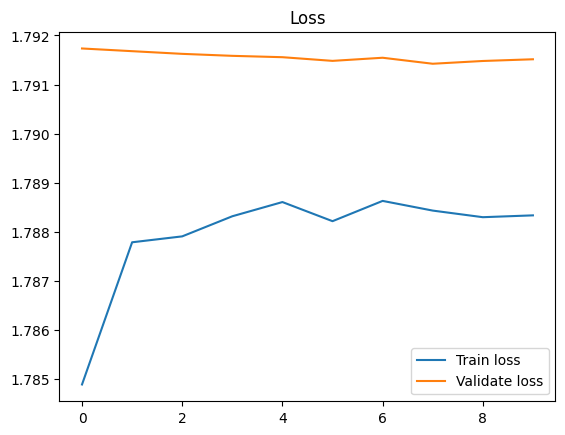

In [132]:
plt.plot(history_loss)
plt.plot(history_val_loss)
plt.legend(['Train loss', 'Validate loss'])
plt.title('Loss')
plt.show()


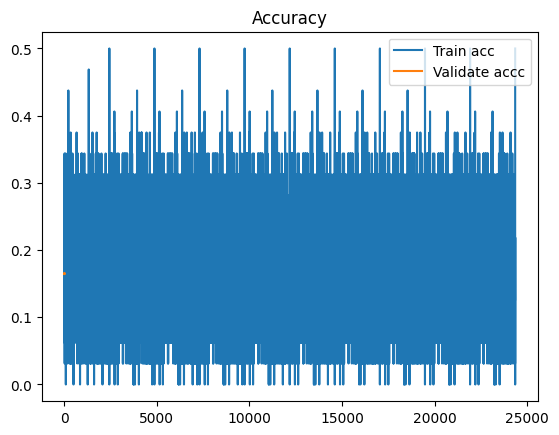

In [133]:
plt.plot(history_acc)
plt.plot(history_val_acc)
plt.legend(['Train acc', 'Validate accc'])
plt.title('Accuracy')
plt.show()


In [134]:
y_pred = model(X_test)
_, y_pred = torch.max(y_pred.data, 1)
y_pred = y_pred.cpu().numpy()

In [135]:
set(y_pred)

{1, 2, 4, 5}

In [72]:
y_test

array([1, 3, 4, ..., 1, 4, 2])

In [62]:
from sklearn.metrics import f1_score

In [136]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f'Macro: {f1_macro}')
print(f'Micro: {f1_micro}')
print(f'Weighted: {f1_weighted}')

Macro: 0.0478059675450341
Micro: 0.16160215674947045
Weighted: 0.046378892998556596
